# Final Architecture

**Added more convolutional and residual layers**

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [4]:
torch.__version__

'1.7.1+cu110'

In [5]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

##### Creating a function for getting training data CIFAR100

In [6]:
def give_me_train_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a train dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    # defining the transformations on the train data
    
    transformations = [transforms.RandomCrop(32, padding=4),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)]
    transform_train = transforms.Compose(transformations)
    
    train_set = CIFAR100('./data/cifar100', train=True, 
                         download=True, transform=transform_train)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = bs,
                                               shuffle=True, num_workers=num_workers)
    return train_loader

def give_me_test_data(bs=128, num_workers=2, shuffle=True):
    ''' would return a test dataloader for CIFAR100'''
    mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
    std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
    
    # defining transformations on the test data
    
    transformations = [transforms.ToTensor(), transforms.Normalize(mean, std)]
    transform_test = transforms.Compose(transformations)
    
    valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=transform_test)
    val_loader = torch.utils.data.DataLoader(valid_set, batch_size=bs, shuffle=False, 
                                             num_workers=num_workers)
    return val_loader

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kz, pad, stride=1):
        super(Block, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        else:
            self.skip = None

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kz, padding=pad, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kz, padding=pad, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        
    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        out = F.relu(out)

        return out    

In [8]:
def _conv_block(in_f, out_f, activation = True, *args, **kwargs):
    if activation:
        return nn.Sequential(
            nn.Conv2d(in_f, out_f, *args, **kwargs), 
            nn.BatchNorm2d(out_f), 
            nn.ReLU())
    else: 
        return nn.Sequential(
            nn.Conv2d(in_f, out_f, *args, **kwargs), 
            nn.BatchNorm2d(out_f))

class SimpleResnet(nn.Module):
    def __init__(self, in_c, n_classes):
        super(SimpleResnet, self).__init__()
        kz = 5
        st = 1
        padd = 2

        self.conv_basic = _conv_block(in_c, 32, kernel_size = 1, stride = 1, padding = 0)
        self.block1 = Block(32, 64, kz, padd, stride = st)
        self.block11 = Block(64, 64, kz, padd, stride = st)
        self.block111 = Block(64, 64, kz, padd, stride = st)

        self.block2 = Block(64, 128, kz, padd, stride = st)
        self.block22 = Block(128, 128, kz, padd, stride = st)
        self.block222 = Block(128, 128, kz, padd, stride = st)

        self.block3 = Block(128, 256, kz, padd, stride = st)
        self.block33 = Block(256, 256, kz, padd, stride = st)
        self.block333 = Block(256, 256, kz, padd, stride = st)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((2,2))        
        
        self.dense_decoder = nn.Sequential(
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1024), 
            nn.ReLU(),
            nn.Linear(1024, n_classes))
        
    def forward(self, x):
        x = self.conv_basic(x)
        x = self.block1(x)
        x = self.block11(x)
        x = self.block111(x)
        
        x = self.block2(x)
        x = self.block22(x)
        x = self.block222(x)
        
        x = self.block3(x)
        x = self.block33(x)
        x = self.block333(x)
        
        x = self.adaptive_pool(x)

        x = x.view(x.size(0), -1)
#         print(x.size())
        x = self.dense_decoder(x)

        return x

### Creating the model architecture

Adding residual connections to the architecture created in Variation 5


**Sending the model to gpu and printing the summary of the model architecture**

In [9]:
device = 'cuda'
model = SimpleResnet(3, 100)
model.to(device) # sending our model to gpu.

# Printing the summary of our model. 
input_shape = (3, 32, 32)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             128
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          51,200
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]         102,400
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
            Block-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]         102,400
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

##### Preparing our data loaders for training and test.
Batch size is 128 (tried 256 and 512, 128 gives better performance)

In [10]:
train_loader = give_me_train_data(bs = 128, num_workers=4, shuffle=True)
val_loader = give_me_test_data(bs = 128, num_workers=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [12]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
model.apply(init_weights)

SimpleResnet(
  (conv_basic): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Block(
    (skip): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block11): Block(
    (skip): None
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): Bat

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_train = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        # decreasing learning rate with the epochs
        scheduler.step(loss_train)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [14]:
# validate the training on validation set
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        print(name)
        print(loader)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                y = model(imgs)
                _, predicted = torch.max(y, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.4f}".format(name, correct/total))
        print("{}: correct, total = {},{}".format(name, correct, total))

In [16]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 3.8195 Acc: 0.1141
val Loss: 3.5219 Acc: 0.1631

Epoch 2/10
----------
train Loss: 3.2250 Acc: 0.2091
val Loss: 3.1352 Acc: 0.2407

Epoch 3/10
----------
train Loss: 2.8708 Acc: 0.2769
val Loss: 2.7469 Acc: 0.3077

Epoch 4/10
----------
train Loss: 2.5762 Acc: 0.3331
val Loss: 2.7692 Acc: 0.3204

Epoch 5/10
----------
train Loss: 2.3553 Acc: 0.3773
val Loss: 2.3377 Acc: 0.3950

Epoch 6/10
----------
train Loss: 2.1639 Acc: 0.4218
val Loss: 2.3539 Acc: 0.4106

Epoch 7/10
----------
train Loss: 2.0142 Acc: 0.4525
val Loss: 2.0646 Acc: 0.4488

Epoch 8/10
----------
train Loss: 1.8837 Acc: 0.4837
val Loss: 2.0967 Acc: 0.4495

Epoch 9/10
----------
train Loss: 1.7722 Acc: 0.5108
val Loss: 1.9485 Acc: 0.4887

Epoch 10/10
----------
train Loss: 1.6769 Acc: 0.5303
val Loss: 1.8229 Acc: 0.5178

Training complete in 27m 29s
Best val Acc: 0.517800


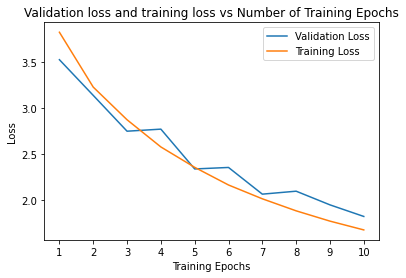

In [17]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [18]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.5486
train: correct, total = 27428,50000
val
Accuracy val: 0.5178
val: correct, total = 5178,10000


Running for another 50 Epochs to check convergence

In [19]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 50

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/50
----------
train Loss: 1.5935 Acc: 0.5515
val Loss: 1.8543 Acc: 0.5084

Epoch 2/50
----------
train Loss: 1.5068 Acc: 0.5707
val Loss: 1.8835 Acc: 0.5058

Epoch 3/50
----------
train Loss: 1.4297 Acc: 0.5900
val Loss: 1.6774 Acc: 0.5544

Epoch 4/50
----------
train Loss: 1.3657 Acc: 0.6080
val Loss: 1.8192 Acc: 0.5273

Epoch 5/50
----------
train Loss: 1.2997 Acc: 0.6231
val Loss: 1.8897 Acc: 0.5316

Epoch 6/50
----------
train Loss: 1.2391 Acc: 0.6392
val Loss: 1.6987 Acc: 0.5592

Epoch 7/50
----------
train Loss: 1.1821 Acc: 0.6536
val Loss: 1.5753 Acc: 0.5849

Epoch 8/50
----------
train Loss: 1.1280 Acc: 0.6659
val Loss: 1.7924 Acc: 0.5607

Epoch 9/50
----------
train Loss: 1.0748 Acc: 0.6792
val Loss: 1.7287 Acc: 0.5633

Epoch 10/50
----------
train Loss: 1.0235 Acc: 0.6944
val Loss: 1.6786 Acc: 0.5841

Epoch 11/50
----------
train Loss: 0.9795 Acc: 0.7051
val Loss: 1.5932 Acc: 0.6052

Epoch 12/50
----------
train Loss: 0.9360 Acc: 0.7166
val Loss: 1.7783 Acc: 0.5694

E

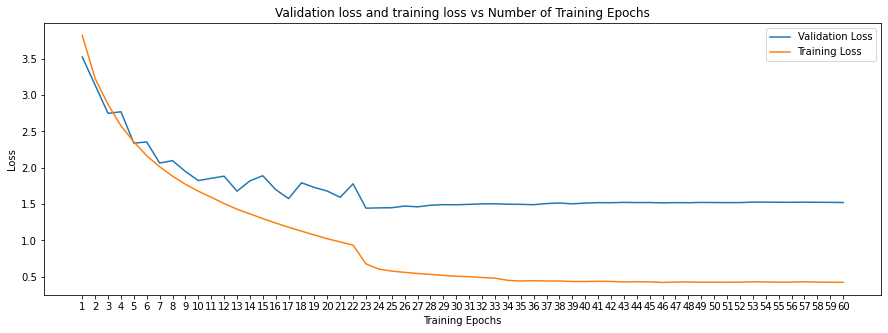

In [25]:
v_loss_1 = [v for v in val_loss_hist]
t_loss_1 = [t for t in train_loss_hist]

v_loss_30 = v_loss + v_loss_1
t_loss_30 = t_loss + t_loss_1

num_epochs = 60
plt.figure(figsize=(15,5))
plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss_30, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss_30, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [21]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.8754
train: correct, total = 43768,50000
val
Accuracy val: 0.6551
val: correct, total = 6551,10000
